In [1]:
import numpy as np
import pandas as pd
import os
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import shapiro, friedmanchisquare, rankdata, ranksums
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pingouin as pg

#0- import data & apply filters
path_data = os.path.join(os.getcwd(), 'data.csv')
df=pd.read_csv(path_data)
df['Steps'] = df['Steps'].fillna(0).astype(int) #we are not interested in decimals
df['Calories'] = df['Calories'].fillna(0).astype(int) #we are not interested in decimals
df = df.drop('Unnamed: 0', axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna(subset=['Date'])
df = df.dropna(subset=['DeviceName'])
df = df.set_index('Date')
df.head()


,ID,oneStep,oneCalorie,DeviceName,measuredHR,dataLostSynch,Steps,Calories,Method1,Method2,Method3,MethodHR
Date,,,,,,,,,,,,
2020-10-22,001,True,True,Alta,False,False,16193,2451,True,True,True,False
2020-10-23,001,True,True,Alta,False,False,8990,1907,False,True,True,False
2020-10-24,001,True,True,Alta,False,False,12425,2096,False,True,True,False
2020-10-25,001,True,True,Alta,False,False,9610,1993,False,True,True,False
2020-10-26,001,True,True,Alta,False,False,7661,1875,False,True,True,False


Number of steps realised ('Steps') and calories spend ('Calories') for each day of observation ('Date') of each participant ('ID'). In addition, the data contains the filters applied: 1 step and 1 calories in the whole day ('oneStep' and 'oneCalorie'), difference between min-per-min and daily data ('dataLostSynch'), tracker with heart rate acquisition ('DeviceName' and 'measuredHR'). At last, the different filters for valid wear for each days based on our software ('Method1', 'Method2' and 'MethodHR').

# 1- Descriptive Statistics

In [2]:
#1- Number of days of observation per individual 
days_per_id = df.groupby('ID').size()
weeks_per_id = days_per_id / 7
mean_days = days_per_id.mean()
std_days = days_per_id.std()
mean_weeks = weeks_per_id.mean()
std_weeks = weeks_per_id.std()

print('Before any filters')
print(f"Number of days of observation per participants: {mean_days:.2f} +/- {std_days:.2f}")
print(f"Number of weeks of observation per participants: {mean_weeks:.2f} +/- {std_weeks:.2f}")
print('')

#2- Number of days and of participants considered depending on filters applied
print(f"Raw data: ..........................................{len(df)} days, {df['ID'].nunique()} participants")
print(df.describe().round(2))
print('')
# days measured with trackers containing HR lens, i.e. Alta HR or Inspire 2
mask_device = (df['DeviceName'] == 'Alta HR') | (df['DeviceName'] == 'Inspire 2')
df_filtered = df[mask_device]
print(f"Correct trackers (Alta HR or Inspire 2):...........{len(df_filtered)} days, {df_filtered['ID'].nunique()} participants")
print(df_filtered.describe().round(2))
print('')
# days with HR measured (HR lens not disabled)
mask_hr_mesured = df_filtered['measuredHR'] == True
df_filtered = df_filtered[mask_hr_mesured]
print(f"HR lens activated enabled:..........................{len(df_filtered)} days, {df_filtered['ID'].nunique()} participants")
print(df_filtered.describe().round(2))
print('')
# days with one step and one calorie reccorded
mask_1step = df_filtered['oneStep'] & df_filtered['oneCalorie'] == True
df_filtered = df_filtered[mask_1step]
print(f"One step and one calorie recorded:..................{len(df_filtered)} days, {df_filtered['ID'].nunique()} participants")
print(df_filtered.describe().round(2))
print('')
# days with no difference between min-per-min and daily data
mask_diff = df_filtered['dataLostSynch'] == False
df_filtered = df_filtered[mask_diff]
print(f"No difference between min-per-min and daily data: ...{len(df_filtered)} days, {df_filtered['ID'].nunique()} participants")
print(df_filtered.describe().round(2))
print('')

df_final = df_filtered

# days with valid wear according to method1 
mask_method1 = df_filtered['Method1'] == True
df_filtered1 = df_filtered[mask_method1]
print(f"Valid wear according to method1:....................{len(df_filtered1)} days, {df_filtered1['ID'].nunique()} participants")
print(df_filtered1.describe().round(2))
print('')
# days with valid wear according to method2 
mask_method2 = df_filtered['Method2'] == True
df_filtered2 = df_filtered[mask_method2]
print(f"Valid wear according to method2:.....................{len(df_filtered2)} days, {df_filtered2['ID'].nunique()} participants")
print(df_filtered2.describe().round(2))
print('')
# days with valid wear according to methodHR 
mask_methodHR = df_filtered['MethodHR'] == True
df_filteredHR = df_filtered[mask_methodHR]
print(f"Valid wear according to methodHR:....................{len(df_filteredHR)} days, {df_filteredHR['ID'].nunique()} participants")
print(df_filteredHR.describe().round(2))
print('')


Before any filters
Number of days of observation per participants: 72.15 +/- 40.75
Number of weeks of observation per participants: 10.31 +/- 5.82

Raw data: ..........................................8946 days, 124 participants
          Steps  Calories
count   8946.00   8946.00
mean    8383.63   2381.70
std     5768.52    653.94
min        0.00      0.00
25%     4229.75   1909.00
50%     8013.00   2311.00
75%    11591.75   2733.00
max    40855.00   9108.00

Correct trackers (Alta HR or Inspire 2):...........5077 days, 81 participants
          Steps  Calories
count   5077.00   5077.00
mean    8430.78   2589.56
std     5614.93    702.09
min        0.00      0.00
25%     4485.00   2115.00
50%     8130.00   2532.00
75%    11566.00   2959.00
max    40855.00   6394.00

HR lens activated enabled:..........................4920 days, 74 participants
          Steps  Calories
count   4920.00   4920.00
mean    8380.15   2596.78
std     5582.83    705.35
min        0.00      0.00
25%     4485.00

# 2- Analytic Statistics
## 2.1- Categorial approach

In [3]:
#1- Agreement rates

validWearColumns = ['Method1', 'Method2']
y_true = df_final['MethodHR'].astype(int)  # Convert boolean to binary (0 or 1)

for column in validWearColumns:
    y_pred = df_final[column].astype(int)  # Convert boolean to binary (0 or 1)
    agreement_count = df_final[(y_true == 1) & (y_pred == 1)].shape[0]
    total_count = df_final.shape[0]

    # Agreement rate
    agreement_rate = (agreement_count / total_count) * 100
    print(f" Between 'MethodHR' and '{column}' = {agreement_rate:.2f}%")
    print(f"Agreement rate: {agreement_rate:.2f}%")

    # Accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print("")


 Between 'MethodHR' and 'Method1' = 70.50%
Agreement rate: 70.50%
Accuracy: 0.83
Precision: 0.98
Recall: 0.82
F1-score: 0.89

 Between 'MethodHR' and 'Method2' = 85.91%
Agreement rate: 85.91%
Accuracy: 0.92
Precision: 0.92
Recall: 1.00
F1-score: 0.96



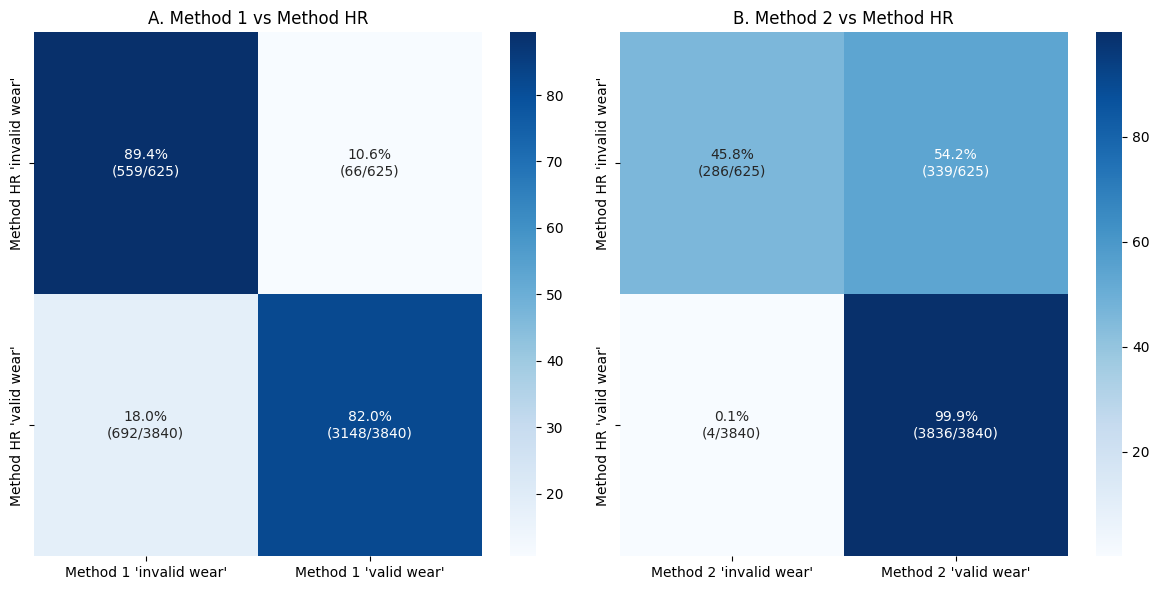

In [4]:
#2- Confusion matrix

# First columns pair
y_true_pair1 = df_final['MethodHR'].astype(int)  # Convert boolean to binary (0 or 1)
y_pred_pair1 = df_final['Method1'].astype(int)  # Convert boolean to binary (0 or 1)
cm_pair1 = confusion_matrix(y_true_pair1, y_pred_pair1)
# Second columns pair
y_true_pair2 = df_final['MethodHR'].astype(int)  # Convert boolean to binary (0 or 1)
y_pred_pair2 = df_final['Method2'].astype(int)  # Convert boolean to binary (0 or 1)
cm_pair2 = confusion_matrix(y_true_pair2, y_pred_pair2)
# Numbers to percentages in cells
cm_pair1_percent = cm_pair1 / cm_pair1.sum(axis=1)[:, np.newaxis] * 100
cm_pair2_percent = cm_pair2 / cm_pair2.sum(axis=1)[:, np.newaxis] * 100
cm_pair1_labels = np.array([f"{value:.1f}%\n({int(count)}/{int(total)})"
                            for value, count, total in zip(cm_pair1_percent.flatten(), cm_pair1.flatten(), cm_pair1.sum(axis=1).repeat(2))]).reshape(2,2)
cm_pair2_labels = np.array([f"{value:.1f}%\n({int(count)}/{int(total)})"
                            for value, count, total in zip(cm_pair2_percent.flatten(), cm_pair2.flatten(), cm_pair2.sum(axis=1).repeat(2))]).reshape(2,2)

# Ploting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First matrix
sns.heatmap(cm_pair1_percent, annot=cm_pair1_labels, fmt="", cmap="Blues", xticklabels=["Method 1 'invalid wear'", "Method 1 'valid wear'"], 
            yticklabels=["Method HR 'invalid wear'", "Method HR 'valid wear'"], ax=axes[0])
axes[0].set_title("A. Method 1 vs Method HR")

# Second matrix
sns.heatmap(cm_pair2_percent, annot=cm_pair2_labels, fmt="", cmap="Blues", xticklabels=["Method 2 'invalid wear'", "Method 2 'valid wear'"], 
            yticklabels=["Method HR 'invalid wear'", "Method HR 'valid wear'"], ax=axes[1])
axes[1].set_title("B. Method 2 vs Method HR")

plt.tight_layout()
plt.show()


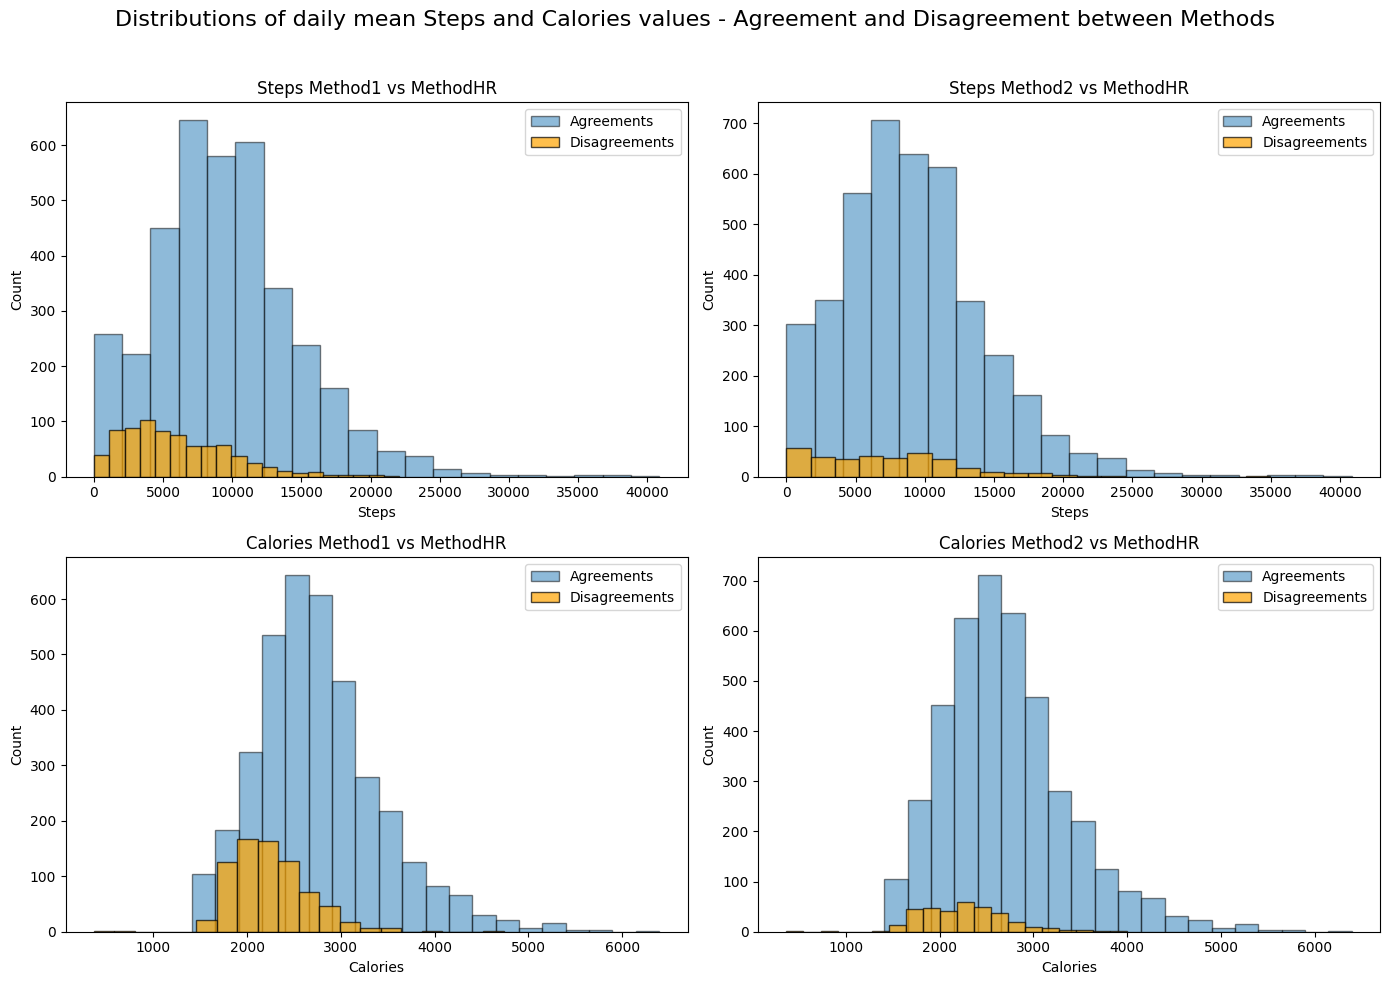

In [19]:
#3- Distribution of disgreement according to the Steps and Calories values

df = df_final.reset_index(drop=True)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

def plot_histogram_with_disagreements(df, method1_col, methodHR_col, measure_col, ax, title):
    df_disagreement = df[df[method1_col] != df[methodHR_col]]
    df_agreement = df[df[method1_col] == df[methodHR_col]]
    # Calculate statistical values for the measure with disagreements
    q1_dis_val = df_disagreement[measure_col].quantile(0.25)
    median_dis_val = df_disagreement[measure_col].median()
    q3_dis_val = df_disagreement[measure_col].quantile(0.75)
    # Histogram of the measure for agreements 
    ax.hist(df_agreement[measure_col], bins=20, edgecolor='k', alpha=0.5, label='Agreements')
    # Histogram of the measure for disagreements
    ax.hist(df_disagreement[measure_col], bins=20, edgecolor='k', alpha=0.7, label='Disagreements', color='orange')
    # Add lines for quartiles and median for disagreements
    # ax.axvline(q1_dis_val, color='b', linestyle='dashed', linewidth=2, label=f'Dis. Q1: {q1_dis_val}')
    # ax.axvline(median_dis_val, color='r', linestyle='dashed', linewidth=2, label=f'Dis. Q2: {median_dis_val}')
    # ax.axvline(q3_dis_val, color='m', linestyle='dashed', linewidth=2, label=f'Dis. Q3: {q3_dis_val}')
    # Some adjustments
    ax.set_xlabel(measure_col)
    ax.set_ylabel('Count')
    ax.set_title(title)
    ax.legend()
    # ax.grid(True)

plot_histogram_with_disagreements(df, 'Method1', 'MethodHR', 'Steps', axs[0, 0], 'Steps Method1 vs MethodHR')
plot_histogram_with_disagreements(df, 'Method2', 'MethodHR', 'Steps', axs[0, 1], 'Steps Method2 vs MethodHR')
plot_histogram_with_disagreements(df, 'Method1', 'MethodHR', 'Calories', axs[1, 0], 'Calories Method1 vs MethodHR')
plot_histogram_with_disagreements(df, 'Method2', 'MethodHR', 'Calories', axs[1, 1], 'Calories Method2 vs MethodHR')

plt.suptitle('Distributions of daily mean Steps and Calories values - Agreement and Disagreement between Methods', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


## 2.3- Distribution analysis - day wise

In [11]:
#3- Distribution analysis - all days and all participants together
df_anova = df_final[['ID', 'Steps', 'Calories', 'Method1', 'Method2', 'MethodHR']].copy()

model_steps = ols('Steps ~ C(Method1) * C(Method2) * C(MethodHR)', data=df_anova).fit()
anova_table_steps = sm.stats.anova_lm(model_steps, typ=2)

model_calories = ols('Calories ~ C(Method1) * C(Method2) * C(MethodHR)', data=df_anova).fit()
anova_table_calories = sm.stats.anova_lm(model_calories, typ=2)

print("ANOVA for Steps :")
print(anova_table_steps)
print('')
print("ANOVA for Calories :")
print(anova_table_calories)


ANOVA for Steps :
                                         sum_sq      df             F  \
C(Method1)                        -1.675997e-01     1.0 -7.314661e-09   
C(Method2)                         9.602699e-01     1.0  4.190969e-08   
C(MethodHR)                       -9.799684e+08     1.0 -4.276940e+01   
C(Method1):C(Method2)              1.049905e-04     1.0  4.582170e-12   
C(Method1):C(MethodHR)                      NaN     1.0           NaN   
C(Method2):C(MethodHR)             1.323688e+07     1.0  5.777058e-01   
C(Method1):C(Method2):C(MethodHR)  8.366419e+06     1.0  3.651411e-01   
Residual                           1.021454e+11  4458.0           NaN   

                                     PR(>F)  
C(Method1)                         1.000000  
C(Method2)                         0.999837  
C(MethodHR)                        1.000000  
C(Method1):C(Method2)              0.999998  
C(Method1):C(MethodHR)                  NaN  
C(Method2):C(MethodHR)             0.447253  
C(

/Users/mgg/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1896: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/Users/mgg/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1925: RuntimeWarning: invalid value encountered in divide
  F /= J


We found no effect of the method applied (1,2 or HR) on Steps (p = 0.534521) nor Calories (p = 0.662464). This may be due to high differences between subjects. We therefore go with a subject-wise analysis.

## 2.4- Distribution analysis - subject wise

In [12]:
#4- Distribution analysis - mean daily physical activity, subject wise

def mean_steps_by_method(x, method_col):
    return x.loc[x[method_col] == 1, 'Steps'].mean()

def mean_calories_by_method(x, method_col):
    return x.loc[x[method_col] == 1, 'Calories'].mean()

grouped = df_final.groupby('ID').apply(lambda x: pd.Series({
    'StepsMethod1': mean_steps_by_method(x, 'Method1'),
    'StepsMethod2': mean_steps_by_method(x, 'Method2'),
    'StepsMethodHR': mean_steps_by_method(x, 'MethodHR'),
    'StepsAll': x['Steps'].mean(),
    'CaloriesMethod1': mean_calories_by_method(x, 'Method1'),
    'CaloriesMethod2': mean_calories_by_method(x, 'Method2'),
    'CaloriesMethodHR': mean_calories_by_method(x, 'MethodHR'),
    'CaloriesAll': x['Calories'].mean()
})).reset_index()

num_days_observation = df_final.groupby('ID').size().reset_index(name='numDays')
grouped = grouped.merge(num_days_observation, on='ID', how='left')
grouped.head()


/var/folders/24/kprm3l051vg4589bhtmv1_mw0000gn/T/ipykernel_49975/3955468000.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_final.groupby('ID').apply(lambda x: pd.Series({


,ID,StepsMethod1,StepsMethod2,StepsMethodHR,StepsAll,CaloriesMethod1,CaloriesMethod2,CaloriesMethodHR,CaloriesAll,numDays
0,031,13902.000000,13156.066667,13000.000000,12875.387097,3605.000000,3442.266667,3439.931034,3401.774194,31
1,033,12991.321429,11384.500000,12179.705882,10384.720930,4037.392857,3710.947368,3872.323529,3520.860465,43
2,038,9657.080645,8714.831169,9108.394366,8083.705882,2839.919355,2755.415584,2788.450704,2683.458824,85
3,040,NaN,NaN,NaN,2394.000000,NaN,NaN,NaN,1750.000000,1
4,043,9638.288660,9177.860870,9268.314815,8759.819672,2751.814433,2663.860870,2695.416667,2607.336066,122


Mean daily number of steps realised ('Steps') and calories spend ('Calories') for each each participant ('ID') depending on the method applied ('Method1', 'Method2', 'MethodHR', or no method 'All'), as well as number of days considered ('numDays'). 

  
Subject 040 has only 1 day of observation, and so NaN as steps and calories values with different methods. This is because this subject started the experiment with a Fitbit Alta, and changed for an Alta HR late (5 days of observation). All these days contained an issue of synching, wearing etc. We therefore suppress this subject in further analysis.

In [13]:
df_cleaned = grouped[grouped['ID'] != '040']


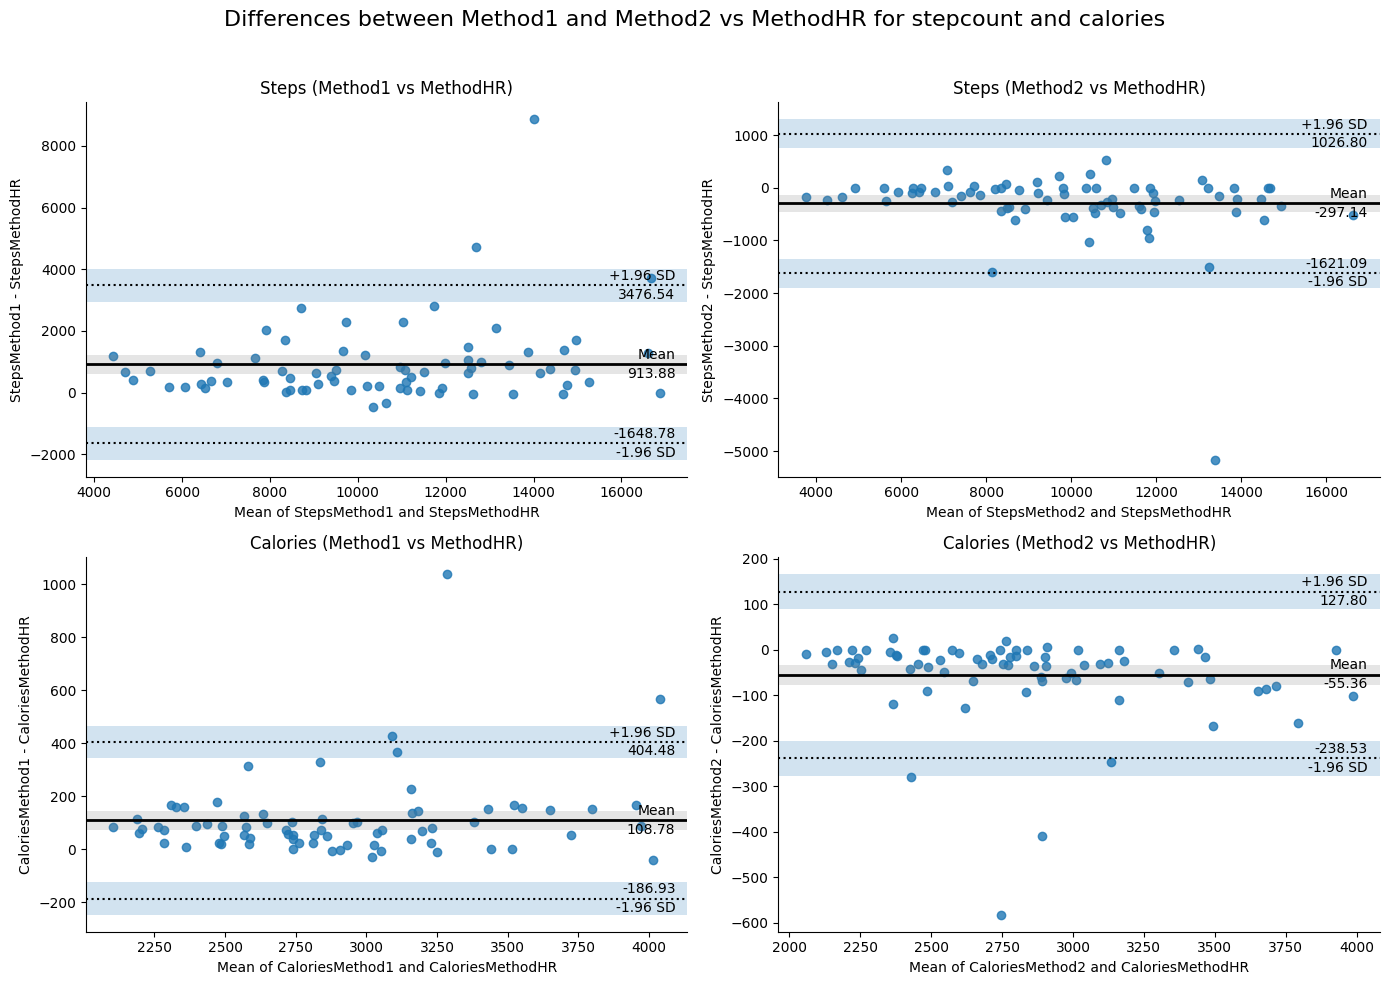

In [20]:
# Set up the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Bland-Altman plot for Steps (Method1 vs MethodHR)
pg.plot_blandaltman(df_cleaned['StepsMethod1'], df_cleaned['StepsMethodHR'], ax=axs[0, 0])
axs[0, 0].set_title('Steps (Method1 vs MethodHR)')

# Bland-Altman plot for Steps (Method2 vs MethodHR)
pg.plot_blandaltman(df_cleaned['StepsMethod2'], df_cleaned['StepsMethodHR'], ax=axs[0, 1])
axs[0, 1].set_title('Steps (Method2 vs MethodHR)')

# Bland-Altman plot for Calories (Method1 vs MethodHR)
pg.plot_blandaltman(df_cleaned['CaloriesMethod1'], df_cleaned['CaloriesMethodHR'], ax=axs[1, 0])
axs[1, 0].set_title('Calories (Method1 vs MethodHR)')

# Bland-Altman plot for Calories (Method2 vs MethodHR)
pg.plot_blandaltman(df_cleaned['CaloriesMethod2'], df_cleaned['CaloriesMethodHR'], ax=axs[1, 1])
axs[1, 1].set_title('Calories (Method2 vs MethodHR)')

# General plot settings
plt.suptitle('Differences between Method1 and Method2 vs MethodHR for stepcount and calories', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



This figure is presented in a different maner in the paper manuscript.

In [15]:
# Test for distribution normality
columns_to_test = ['StepsMethod1', 'StepsMethod2', 'StepsMethodHR', 'StepsAll',
                   'CaloriesMethod1', 'CaloriesMethod2', 'CaloriesMethodHR', 'CaloriesAll']

shapiro_results = {}
for col in columns_to_test:
    stat, p_value = shapiro(df_cleaned[col].dropna())
    shapiro_results[col] = (stat, p_value)

for col, (stat, p_value) in shapiro_results.items():
    print(f'Column: {col}, Statistic: {stat:.4f}, p-value: {p_value:.4f}')
    if p_value > 0.05:
        print(f'   Normality distribution for data in {col} (p > 0.05).')
    else:
        print(f'   NON-normality distribution for data in {col}  (p ≤ 0.05).')
    print('---')


Column: StepsMethod1, Statistic: 0.9846, p-value: 0.5187
   Normality distribution for data in StepsMethod1 (p > 0.05).
---
Column: StepsMethod2, Statistic: 0.9895, p-value: 0.8073
   Normality distribution for data in StepsMethod2 (p > 0.05).
---
Column: StepsMethodHR, Statistic: 0.9895, p-value: 0.8123
   Normality distribution for data in StepsMethodHR (p > 0.05).
---
Column: StepsAll, Statistic: 0.9893, p-value: 0.7959
   Normality distribution for data in StepsAll (p > 0.05).
---
Column: CaloriesMethod1, Statistic: 0.9588, p-value: 0.0177
   NON-normality distribution for data in CaloriesMethod1  (p ≤ 0.05).
---
Column: CaloriesMethod2, Statistic: 0.9577, p-value: 0.0153
   NON-normality distribution for data in CaloriesMethod2  (p ≤ 0.05).
---
Column: CaloriesMethodHR, Statistic: 0.9646, p-value: 0.0383
   NON-normality distribution for data in CaloriesMethodHR  (p ≤ 0.05).
---
Column: CaloriesAll, Statistic: 0.9550, p-value: 0.0109
   NON-normality distribution for data in Calor

As the distribution for Calories value are non normal, we apply a non-parametric test for differences in Steps and Calories distribution between methods 1, 2 and HR.

In [16]:
# Friedman test - global effect
def test_method_effect_global(df, variable):
    print(f"Effect of methods on {variable}:")
    columns = [f"{variable}Method1", f"{variable}Method2", f"{variable}MethodHR", f"{variable}All"]
    try:
        df_filtered = df.dropna(subset=columns)
        stat, p_value = friedmanchisquare(df_filtered[columns[0]], df_filtered[columns[1]], df_filtered[columns[2]])
        print(f"Friedman Test for {variable}: Statistic={stat:.2f}, p-value={p_value:.4f}")
        if p_value < 0.05:
            print("Reject null hypothesis: There is a significant difference between methods.")
        else:
            print("Fail to reject null hypothesis: No significant difference between methods.")
        print()
    except KeyError as e:
        print(f"Error: One or more columns {e} not found in DataFrame.")

print('->Friedman global effect of Method (1x2xHR) on Steps and Calories')
test_method_effect_global(df_cleaned, 'Steps')
test_method_effect_global(df_cleaned, 'Calories')
print('===============================')

# Conover post hoc test
def test_post_hoc_conover(df, variable):
    columns = [f"{variable}Method1", f"{variable}Method2", f"{variable}MethodHR", f"{variable}All"]    
    df_filtered = df.dropna(subset=columns)
    # rank calculation
    ranks = df_filtered[columns].apply(rankdata, axis=1) #rank calculation
    mean_ranks = ranks.mean()
    print(f"Mean Ranks for {variable}:")
    print(mean_ranks)
    print()
    # pairs comparison
    pairs = list(itertools.combinations(columns, 2))
    for pair in pairs:
        print(f"Comparing {pair[0]} vs {pair[1]}:")
        stat, p_value = ranksums(df_filtered[pair[0]], df_filtered[pair[1]])
        print(f"Ranksums Test (Conover) for {pair[0]} vs {pair[1]}: Statistic={stat:.4f}, p-value={p_value:.4f}")
        if p_value < 0.05:
            print("Reject null hypothesis: There is a significant difference between methods.")
        else:
            print("Fail to reject null hypothesis: No significant difference between methods.")
        print()

print('->Conover post-hoc test for pair-wise methods comparison')
test_post_hoc_conover(df_cleaned, 'Steps')
print('-------------------------')
test_post_hoc_conover(df_cleaned, 'Calories')


->Friedman global effect of Method (1x2xHR) on Steps and Calories
Effect of methods on Steps:
Friedman Test for Steps: Statistic=105.83, p-value=0.0000
Reject null hypothesis: There is a significant difference between methods.

Effect of methods on Calories:
Friedman Test for Calories: Statistic=118.49, p-value=0.0000
Reject null hypothesis: There is a significant difference between methods.

->Conover post-hoc test for pair-wise methods comparison
Mean Ranks for Steps:
[3.8630137  2.10273973 2.78082192 1.25342466]

Comparing StepsMethod1 vs StepsMethod2:
Ranksums Test (Conover) for StepsMethod1 vs StepsMethod2: Statistic=2.1448, p-value=0.0320
Reject null hypothesis: There is a significant difference between methods.

Comparing StepsMethod1 vs StepsMethodHR:
Ranksums Test (Conover) for StepsMethod1 vs StepsMethodHR: Statistic=1.5519, p-value=0.1207
Fail to reject null hypothesis: No significant difference between methods.

Comparing StepsMethod1 vs StepsAll:
Ranksums Test (Conover) fo

With a subject-wise approach, we found that the method applied (1, 2 or HR) have a global impact on the daily mean step count and calories spend values. Post-hoc tests showed that the pair-wise difference is statistically significant between methods 1 and 2 for steps. The rest of difference is due to global distribution differences. We represent this with a boxplot figure.

/var/folders/24/kprm3l051vg4589bhtmv1_mw0000gn/T/ipykernel_49975/1435235369.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Method', y='Value_Steps', data=df_steps, ax=axes[0], palette=palette_steps)
/Users/mgg/opt/anaconda3/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/mgg/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/Users/mgg/opt/anaconda3/lib/python3.9/site-packages/seaborn/_base.py:949:

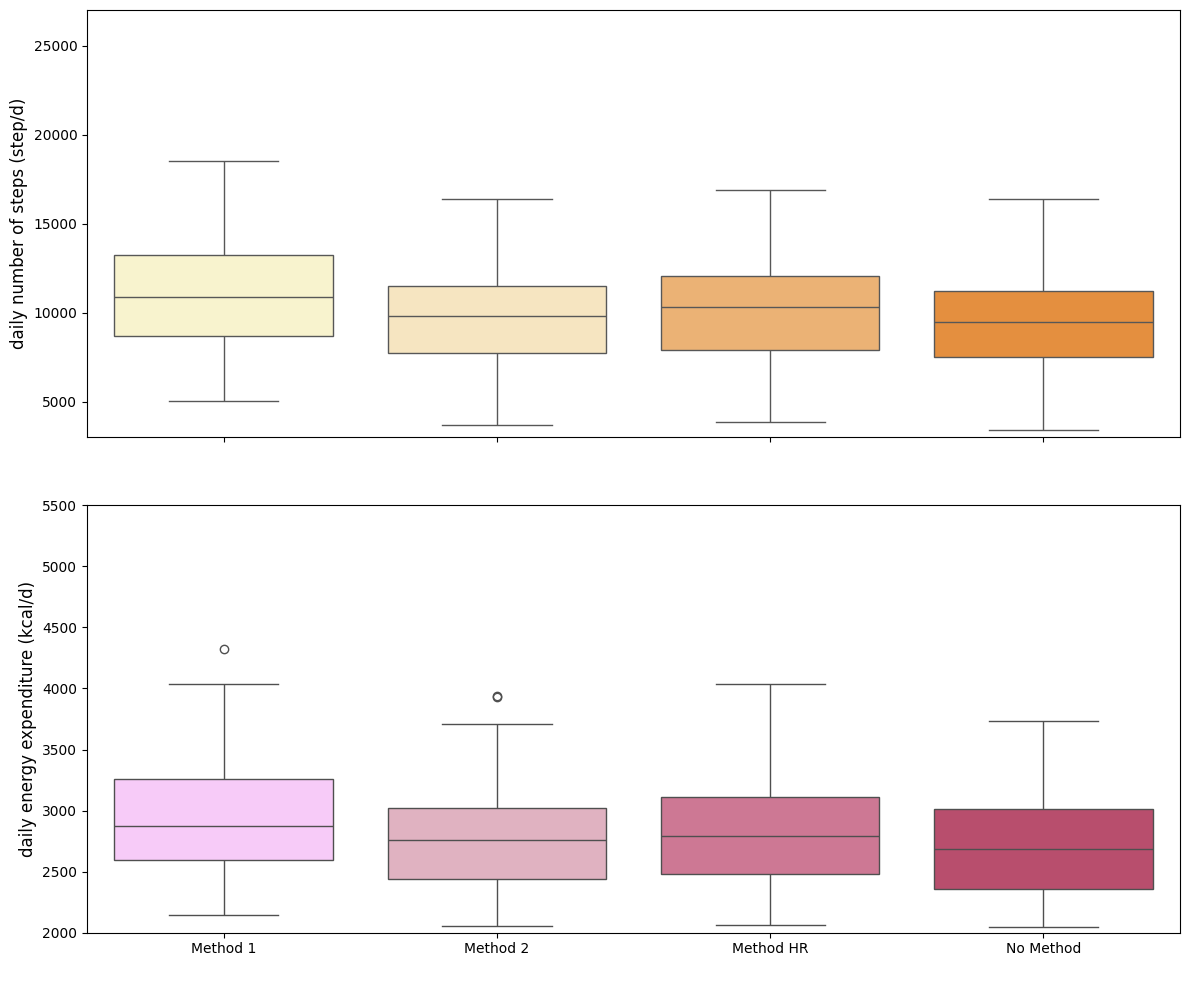

N participants=73
N mean number of days merged = 60.3


In [17]:
# Graphical illustration
df_steps = pd.melt(df_cleaned, id_vars='ID', value_vars=['StepsMethod1', 'StepsMethod2', 'StepsMethodHR', 'StepsAll'], var_name='Method', value_name='Value_Steps')
df_calories = pd.melt(df_cleaned, id_vars='ID', value_vars=['CaloriesMethod1', 'CaloriesMethod2', 'CaloriesMethodHR', 'CaloriesAll'], var_name='Method', value_name='Value_Calories')

fig, axes = plt.subplots(2, 1, figsize=(12, 10))

palette_steps = sns.color_palette(['#fff8c7', '#ffe8b8', '#ffb361', '#ff8e24'])  
palette_calories = sns.color_palette(['#fec4ff', '#E8AABE', '#DB6A8F', '#CA3C66'])  

#Steps
sns.boxplot(x='Method', y='Value_Steps', data=df_steps, ax=axes[0], palette=palette_steps)
#axes[0].set_title('Mean daily physical activity parameters distribution comparison between 3 methods and original data', fontsize=14, weight='bold')
axes[0].set_xlabel(' ', fontsize=12)
#axes[0].set_ylabel('daily step-count per participants', fontsize=12)
axes[0].set_ylabel('daily number of steps (step/d)', fontsize=12)
axes[0].set_ylim(3000, 27000)
axes[0].set_xticklabels([' ', ' ', ' ',' '])


#Calories
sns.boxplot(x='Method', y='Value_Calories', data=df_calories, ax=axes[1], palette=palette_calories)
axes[1].set_xlabel(' ', fontsize=12)
#axes[1].set_ylabel('daily calories per participants', fontsize=12)
axes[1].set_ylabel('daily energy expenditure (kcal/d)', fontsize=12)
axes[1].set_ylim(2000, 5500)
axes[1].set_xticklabels(['Method 1', 'Method 2', 'Method HR', "No Method"])


plt.tight_layout()
#plt.savefig("figure 4.png", dpi='figure')
plt.show()


print(f'N participants={len(df_cleaned)}')
mean_num_days = grouped['numDays'].mean()
print(f'N mean number of days merged = {mean_num_days.round(1)}')


# 3 - Illustration with one participant
Here, we illustrate the impact of our different methods (1, 2 and HR) on the number of days retained and Steps reccorded in one participant (ID = 056).

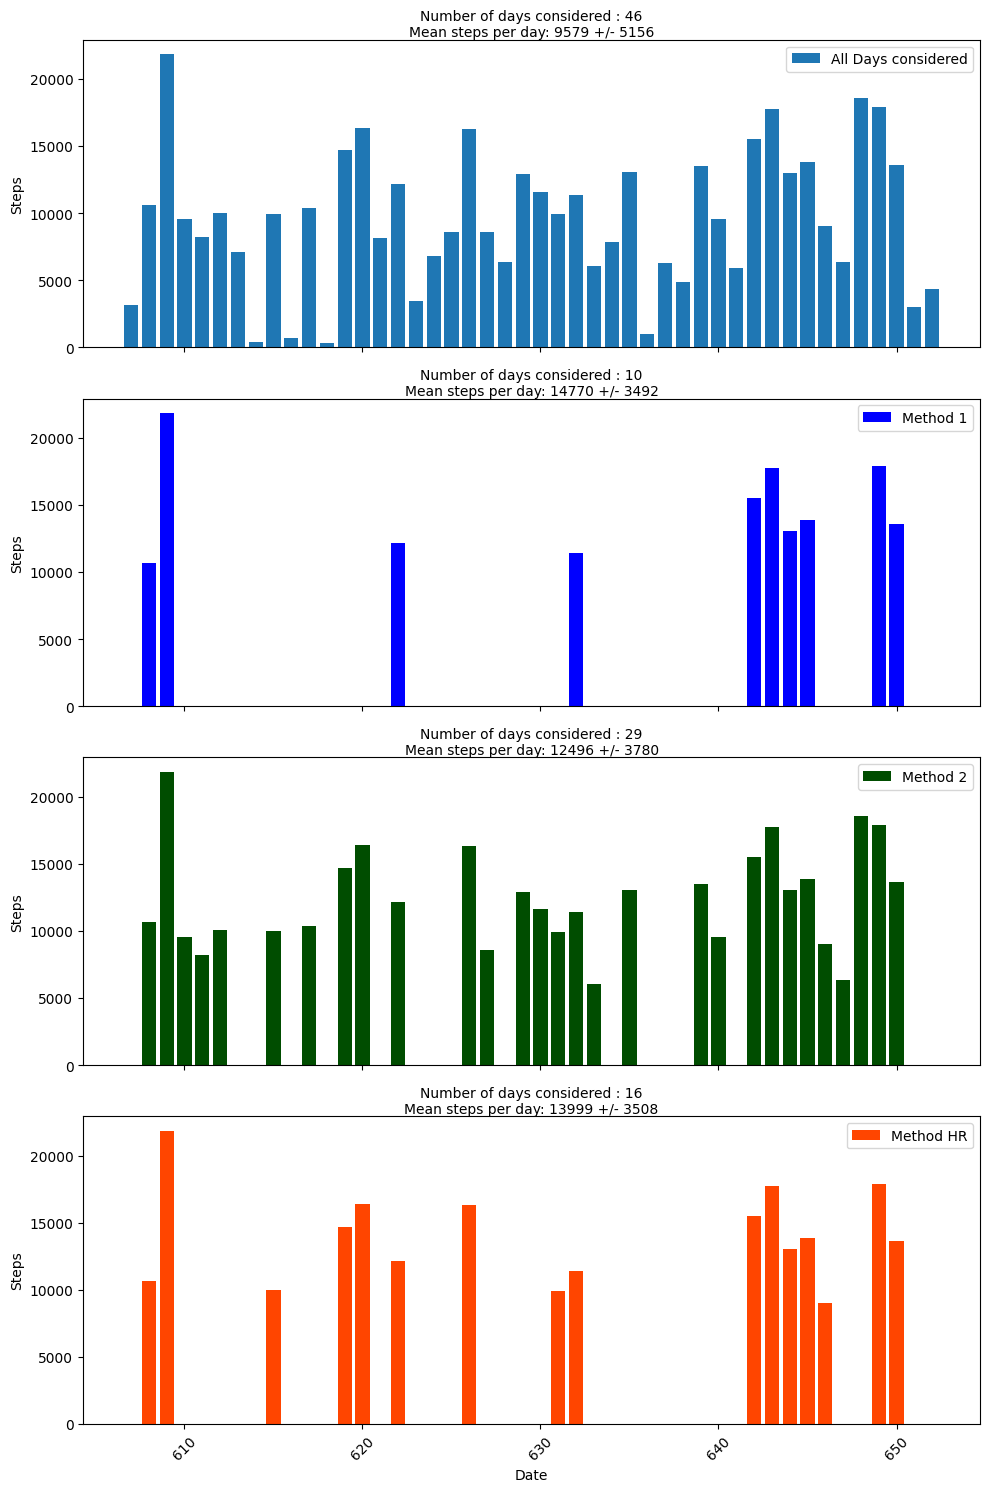

In [18]:
subset_df = df[df['ID'] == '056']

all_days = subset_df
conditionOneStep = subset_df['oneStep'] == True
conditionOneCalorie= subset_df['oneCalorie'] == True
conditionNoDiff = subset_df['dataLostSynch'] == False
considered = subset_df[conditionOneStep & conditionOneCalorie & conditionNoDiff].copy()

methodHR = considered[considered['MethodHR'] == True][['Steps']].copy()
method1 = considered[considered['Method1'] == True][['Steps']].copy()
method2 = considered[considered['Method2'] == True][['Steps']].copy()

fig, axs = plt.subplots(4, 1, figsize=(10, 15), sharex=True)

# All days considered
mean_all_days = all_days['Steps'].mean()
std_all_days = all_days['Steps'].std()
axs[0].bar(all_days.index, all_days['Steps'], label='All Days considered')
axs[0].legend()
axs[0].set_ylabel('Steps')
axs[0].annotate(f"Number of days considered : {len(all_days)}\nMean steps per day: {round(mean_all_days)} +/- {round(std_all_days)}",
                xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center')

# Method1
mean_method1 = method1['Steps'].mean()
std_method1 = method1['Steps'].std()
axs[1].bar(method1.index, method1['Steps'], label='Method 1', color='#0000FF')
axs[1].legend()
axs[1].set_ylabel('Steps')
axs[1].annotate(f"Number of days considered : {len(method1)}\nMean steps per day: {round(mean_method1)} +/- {round(std_method1)}",
                xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center')

# Method2
mean_method2 = method2['Steps'].mean()
std_method2 = method2['Steps'].std()
axs[2].bar(method2.index, method2['Steps'], label='Method 2', color='#004d00')
axs[2].legend()
axs[2].set_ylabel('Steps')
axs[2].annotate(f"Number of days considered : {len(method2)}\nMean steps per day: {round(mean_method2)} +/- {round(std_method2)}",
                xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center')

# MethodHR
mean_methodHR = methodHR['Steps'].mean()
std_methodHR = methodHR['Steps'].std()
axs[3].bar(methodHR.index, methodHR['Steps'], label='Method HR', color='#FF4500')
axs[3].legend()
axs[3].set_xlabel('Date')
axs[3].set_ylabel('Steps')
axs[3].annotate(f"Number of days considered : {len(methodHR)}\nMean steps per day: {round(mean_methodHR)} +/- {round(std_methodHR)}",
                xy=(0.5, 1.05), xycoords='axes fraction', ha='center', va='center')

for ax in axs.flat:
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()
